In [1]:
import torch 
from PIL import Image
import cv2
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
p='000001.jpg'
img_1= Image.open(p)  #PIL格式  其余均为ndarray
img_2=plt.imread(p)
img_3=cv2.imread(p)    #BGR格式
img_4=matplotlib.image.imread(p)
width = img_1.size[0]
height= img_1.size[1]

In [20]:
type(img_1),type(img_2),type(img_3),type(img_4)

(PIL.JpegImagePlugin.JpegImageFile,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

In [4]:
img_2.shape,img_3.shape,img_4.shape

((323, 416, 3), (323, 416, 3), (323, 416, 3))

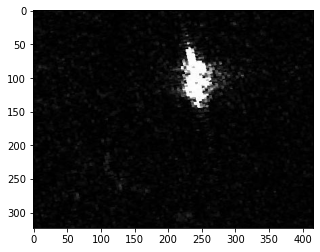

In [5]:
plt.imshow(img_1)
plt.show()

In [6]:
# img_1.show() #显示在弹出的窗口

In [7]:
# cv2.imshow('test',img_3)
# cv2.waitKey (0)  #这行和下一行必须加上  否则显示有问题
# cv2.destroyAllWindows() 

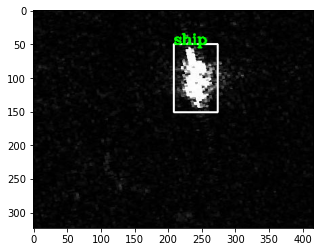

In [8]:
import xml.dom.minidom
import cv2 as cv
imgfile = '000001.jpg' #绝对地址
xmlfile = '000001.xml'#图片对应的xml文件的绝对地址
# print(image)
# 打开xml文档
DOMTree = xml.dom.minidom.parse(xmlfile)
# 得到文档元素对象
collection = DOMTree.documentElement
# 读取图片
img = cv.imread(imgfile)#ndarray格式

filenamelist = collection.getElementsByTagName("filename")
filename = filenamelist[0].childNodes[0].data
# print(filename)
# 得到标签名为object的信息
objectlist = collection.getElementsByTagName("object")#可能含有多个object

for objects in objectlist:
    # 每个object中得到子标签名为name的信息
    namelist = objects.getElementsByTagName('name')
    # 通过此语句得到具体的某个name的值
    objectname = namelist[0].childNodes[0].data

    bndbox = objects.getElementsByTagName('bndbox')
    # print(bndbox)
    for box in bndbox:
        x1_list = box.getElementsByTagName('xmin')
        x1 = int(x1_list[0].childNodes[0].data)
        y1_list = box.getElementsByTagName('ymin')
        y1 = int(y1_list[0].childNodes[0].data)
        x2_list = box.getElementsByTagName('xmax')  # 注意坐标，看是否需要转换
        x2 = int(x2_list[0].childNodes[0].data)
        y2_list = box.getElementsByTagName('ymax')
        y2 = int(y2_list[0].childNodes[0].data)
        cv.rectangle(img, (x1, y1), (x2, y2), (255, 255, 255), thickness=2)
        cv.putText(img, objectname, (x1, y1), cv.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0),
                   thickness=2)
#         plt.imshow('head', img)
#         cv.waitKey(0)  # 这行和下一行必须加上  否则显示有问题
#         cv.destroyAllWindows()
        plt.imshow(img)
        plt.show()

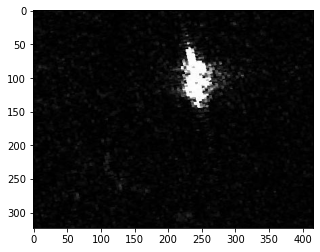

In [9]:
plt.imshow(img_1)
plt.show()

In [10]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib

matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


def aHash(img):
    # 均值哈希算法
    # 缩放为8*8
    img = cv2.resize(img, (8, 8))
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # s为像素和初值为0，hash_str为hash值初值为''
    s = 0
    hash_str = ''
    # 遍历累加求像素和
    for i in range(8):
        for j in range(8):
            s = s + gray[i, j]
    # 求平均灰度
    avg = s / 64
    # 灰度大于平均值为1相反为0生成图片的hash值
    for i in range(8):
        for j in range(8):
            if gray[i, j] > avg:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str


def dHash(img):
    # 差值哈希算法
    # 缩放8*8
    img = cv2.resize(img, (9, 8))
    # 转换灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_str = ''
    # 每行前一个像素大于后一个像素为1，相反为0，生成哈希
    for i in range(8):
        for j in range(8):
            if gray[i, j] > gray[i, j + 1]:
                hash_str = hash_str + '1'
            else:
                hash_str = hash_str + '0'
    return hash_str


def pHash(img):
    # 感知哈希算法
    # 缩放32*32
    img = cv2.resize(img, (32, 32))  # , interpolation=cv2.INTER_CUBIC

    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 将灰度图转为浮点型，再进行dct变换
    dct = cv2.dct(np.float32(gray))
    # opencv实现的掩码操作
    dct_roi = dct[0:8, 0:8]

    hash = []
    avreage = np.mean(dct_roi)
    for i in range(dct_roi.shape[0]):
        for j in range(dct_roi.shape[1]):
            if dct_roi[i, j] > avreage:
                hash.append(1)
            else:
                hash.append(0)
    return hash


def calculate(image1, image2):
    # 灰度直方图算法
    # 计算单通道的直方图的相似值
    hist1 = cv2.calcHist([image1], [0], None, [256], [0.0, 255.0])
    hist2 = cv2.calcHist([image2], [0], None, [256], [0.0, 255.0])
    # 计算直方图的重合度
    degree = 0
    for i in range(len(hist1)):
        if hist1[i] != hist2[i]:
            degree = degree + \
                     (1 - abs(hist1[i] - hist2[i]) / max(hist1[i], hist2[i]))
        else:
            degree = degree + 1
    degree = degree / len(hist1)
    return degree


def classify_hist_with_split(image1, image2, size=(256, 256)):
    # RGB每个通道的直方图相似度
    # 将图像resize后，分离为RGB三个通道，再计算每个通道的相似值
    image1 = cv2.resize(image1, size)
    image2 = cv2.resize(image2, size)
    sub_image1 = cv2.split(image1)
    sub_image2 = cv2.split(image2)
    sub_data = 0
    for im1, im2 in zip(sub_image1, sub_image2):
        sub_data += calculate(im1, im2)
    sub_data = sub_data / 3
    return sub_data


def cmpHash(hash1, hash2):
    # Hash值对比
    # 算法中1和0顺序组合起来的即是图片的指纹hash。顺序不固定，但是比较的时候必须是相同的顺序。
    # 对比两幅图的指纹，计算汉明距离，即两个64位的hash值有多少是不一样的，不同的位数越小，图片越相似
    # 汉明距离：一组二进制数据变成另一组数据所需要的步骤，可以衡量两图的差异，汉明距离越小，则相似度越高。汉明距离为0，即两张图片完全一样
    n = 0
    # hash长度不同则返回-1代表传参出错
    if len(hash1) != len(hash2):
        return -1
    # 遍历判断
    for i in range(len(hash1)):
        # 不相等则n计数+1，n最终为相似度
        if hash1[i] != hash2[i]:
            n = n + 1
    return n


def getImageByUrl(url):
    # 根据图片url 获取图片对象
    html = requests.get(url, verify=False)
    image = Image.open(BytesIO(html.content))
    return image


def PILImageToCV():
    # PIL Image转换成OpenCV格式
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = Image.open(path)
    plt.subplot(121)
    plt.imshow(img)
    print(isinstance(img, np.ndarray))
    img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
    print(isinstance(img, np.ndarray))
    plt.subplot(122)
    plt.imshow(img)
    plt.show()


def CVImageToPIL():
    # OpenCV图片转换为PIL image
    path = "/Users/waldenz/Documents/Work/doc/TestImages/t3.png"
    img = cv2.imread(path)
    # cv2.imshow("OpenCV",img)
    plt.subplot(121)
    plt.imshow(img)

    img2 = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(122)
    plt.imshow(img2)
    plt.show()


def bytes_to_cvimage(filebytes):
    # 图片字节流转换为cv image
    image = Image.open(filebytes)
    img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
    return img

In [11]:
# Image.crop(left, up, right, below)
# left：与左边界的距离
# up：与上边界的距离
# right：还是与左边界的距离
# below：还是与上边界的距离
n1=[]
n2=[]
n3=[]
n4=[]
n5=[]
correlation1=[]
correlation2=[]
xc=(x1+x2)/2
yc=(y1+y2)/2
yu=yc
yd=height-yc
xc_1=xc
s=0.5
for i in np.arange(s,2,0.001):
    i=round(i,2)
    yc_1=yc*i
    height_scaled=int(height*i)

    img_scaled=img_1.resize((width,height_scaled),Image.ANTIALIAS)
                                                                                                                            
    box=(0,yc_1-yu,width,yc_1+yd)
#     print(box)
    img_crop=img_scaled.crop(box)
#     if i==0.5 or i==1 or i==1.5 or i==2:
#         cv2.imshow('test',np.asarray(img_crop))
#         cv2.waitKey(0)  #这行和下一行必须加上  否则显示有问题
#         cv2.destroyAllWindows() 
    img1 = np.asarray(img)#PIL格式转ndarray
    img2 = np.asarray(img_crop)

    img1_t=torch.from_numpy(img1)
    img1_t.transpose_(0,2)
    img1_t=img1_t[1,:,:]    
    img2_t=torch.from_numpy(img2)
    img2_t.transpose_(0,2)
    img2_t=img2_t[1,:,:]
    
    img1_row=img1_t.reshape(-1)
    img2_row=img2_t.reshape(-1)
    
#     temp=np.corrcoef(np.array(img1_row),np.array(img2_row))
#     correlation1.append(temp[0][1])
    
#     t1=img1_t.squeeze(0)
#     t2=img2_t.squeeze(0)
#     img1_t_norm=t1.numpy()-np.mean(t1.numpy())
#     img2_t_norm=t2.numpy()-np.mean(t2.numpy())
   
#     temp_cor = np.sum(img1_t_norm * img2_t_norm) / np.sqrt(np.sum(img1_t_norm * img1_t_norm) * np.sum(img2_t_norm* img2_t_norm));
#     correlation2.append(temp_cor)
    hash1 = aHash(img1)
    hash2 = aHash(img2)
    n1.append(1-float(cmpHash(hash1, hash2)/64))
    # print('均值哈希算法相似度aHash：', n1)

    hash1 = dHash(img1)
    hash2 = dHash(img2)
    n2.append(1-float(cmpHash(hash1, hash2)/64))

    # print('差值哈希算法相似度dHash：', n2)

    hash1 = pHash(img1)
    hash2 = pHash(img2)
    n3.append(1-float(cmpHash(hash1, hash2)/64))

    # print('感知哈希算法相似度pHash：', n3)
    n4.append(classify_hist_with_split(img1, img2))

    # print('三直方图算法相似度：', n4)
    n5.append(calculate(img1, img2))


In [12]:
# plt.plot(np.arange(s,2,0.005),n1,color='red', linewidth=1)

In [13]:
# plt.plot(np.arange(s,2,0.005),n2,color='red', linewidth=1)

In [14]:
# plt.plot(np.arange(s,2,0.005),n3,color='red', linewidth=1)

In [15]:
# plt.plot(np.arange(s,2,0.005),n4,color='red', linewidth=1)

(0.5, 2.0)

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "c:\users\razer\anaconda3\envs\pytorch131\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done: <matplotlib.back

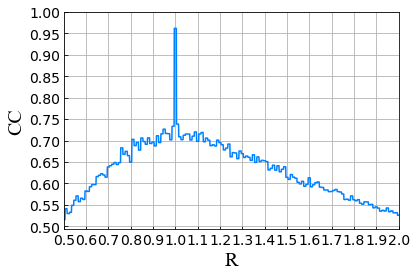

In [16]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 20,
         }
plt.xlabel('R',font1)
plt.ylabel('CC',font1)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(np.arange(s,2,0.001),n5,color=(0,0.5,1), linewidth=1.5)
plt.grid(True)
plt.xticks(np.arange(s,2+0.1, 0.1))
plt.yticks(np.arange(0.5,1+0.05,0.05))
plt.xlim([s,2])

In [17]:
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'

# font1 = {'family': 'Times New Roman',
#          'weight': 'normal',
#          'size': 20,
#          }
# plt.xlabel('R',font1)
# plt.ylabel('CC',font1)
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.plot(np.arange(s,2,0.005),correlation1,color=(0,0.5,1), linewidth=2)
# plt.grid(True)
# plt.xticks(np.arange(s,2+0.1, 0.1))
# plt.yticks(np.arange(0.5,0.9+0.05,0.05))
# plt.xlim([s,2])

In [18]:
# plt.plot(np.arange(s,2,0.005),correlation2,color='red', linewidth=1)
